# Derivative Dynamics Initial Validation

### We are trying to prove or (falsify) the core claims by estimating:
1. Analytic Radius (R) from factorial-normalized Taylor coefficients
2. Spectral Edge (Ω) from L2 norms of repeated derivatives
3. Cyclic Behavior (e.g., sin/cos four-cycle)

## Imports

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from dataclasses import dataclass

# SymPy for exact high-order derivatives at a point
import sympy as sp
sp.init_printing()

## Utitlities: weighted least squares, CIs, plotting

In [2]:
@dataclass
class WLSResult:
    alpha: float                # slope on n
    beta: float                 # intercept
    kappa: float | None         # coefficient on log n (if used)
    se_alpha: float             # standard error of alpha
    ci_alpha: tuple[float,float]# 95% CI for alpha
    X: np.ndarray               # design used
    y: np.ndarray               # targets
    w: np.ndarray               # weights
    resid: np.ndarray           # residuals
    r2: float                   # weighted R^2


In [3]:
def _wls_fit(X, y, w):
    # Solve (X^T W X) beta = X^T W y
    W = np.diag(w)
    XtW = X.T @ W
    XtWX = XtW @ X
    XtWy = XtW @ y
    beta = np.linalg.solve(XtWX, XtWy)

    # Residuals and variance estimate
    y_hat = X @ beta
    resid = y - y_hat
    p = X.shape[1]
    dof = max(1, len(y) - p)

    # Weighted residual variance (sigma^2)
    sigma2 = float(resid.T @ W @ resid) / dof
    cov_beta = sigma2 * np.linalg.inv(XtWX)
    se = np.sqrt(np.diag(cov_beta))

    # Weighted R^2
    y_bar = (w @ y) / np.sum(w)
    ss_tot = (w * (y - y_bar)**2).sum()
    ss_res = (w * resid**2).sum()
    r2 = 1.0 - (ss_res / ss_tot if ss_tot > 0 else np.nan)

    return beta, se, resid, r2

In [4]:
def wls_linear(n, y, weight_scheme=("poly", 1.0, 1.0)):
    """
    Fit y ~ beta + alpha * n (weighted).
    weight_scheme:
      ("poly", gamma, delta): w_n = 1 / (1 + gamma*n)^delta
      ("const", _, _):       w_n = 1
    """
    n = np.asarray(n, dtype=float)
    y = np.asarray(y, dtype=float)

    if weight_scheme[0] == "poly":
        _, gamma, delta = weight_scheme
        w = 1.0 / (1.0 + gamma * n) ** delta
    else:
        w = np.ones_like(n)

    X = np.column_stack([np.ones_like(n), n])  # [beta, alpha]
    beta_vec, se, resid, r2 = _wls_fit(X, y, w)
    beta, alpha = beta_vec
    se_alpha = se[1]
    z = 1.96

    return WLSResult(alpha=alpha, beta=beta, kappa=None,
                     se_alpha=se_alpha,
                     ci_alpha=(alpha - z*se_alpha, alpha + z*se_alpha),
                     X=X, y=y, w=w, resid=resid, r2=r2)

In [5]:
def wls_linear_with_log(n, y, weight_scheme=("poly", 1.0, 1.0)):
    """
    Fit y ~ beta + alpha * n + kappa * log n  (for analytic case with singularity type p)
    Uses n>=2 to avoid log(1)=0 instability in tiny samples.
    """
    n = np.asarray(n, dtype=float)
    y = np.asarray(y, dtype=float)

    if weight_scheme[0] == "poly":
        _, gamma, delta = weight_scheme
        w = 1.0 / (1.0 + gamma * n) ** delta
    else:
        w = np.ones_like(n)

    X = np.column_stack([np.ones_like(n), n, np.log(n)])
    beta_vec, se, resid, r2 = _wls_fit(X, y, w)
    beta, alpha, kappa = beta_vec
    se_alpha = se[1]
    z = 1.96

    return WLSResult(alpha=alpha, beta=beta, kappa=kappa,
                     se_alpha=se_alpha,
                     ci_alpha=(alpha - z*se_alpha, alpha + z*se_alpha),
                     X=X, y=y, w=w, resid=resid, r2=r2)

In [6]:
def linefit_plot(n, y, fit: WLSResult, title, xlabel, ylabel, annotate=None):

    n = np.asarray(n, float)
    plt.figure(figsize=(7,5))
    plt.plot(n, y, 'o', ms=4, label='data', alpha=0.7)

    # Pred line
    yhat = fit.X @ np.array([fit.beta, fit.alpha] if fit.kappa is None else [fit.beta, fit.alpha, fit.kappa])

    plt.plot(n, yhat, '-', lw=2.0, label=f'WLS fit (R^2={fit.r2:.4f})')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if annotate is not None:
        plt.text(0.02, 0.02, annotate, transform=plt.gca().transAxes,
                 fontsize=10, family='monospace', va='bottom', ha='left',
                 bbox=dict(boxstyle='round', alpha=0.1))

    plt.legend()
    plt.grid(True, alpha=0.25)

    plt.show()

## Analytic @ a point: recover radius R from factorial-normalized derivatives

Here, $y_n = \frac{f^n (0)}{n!}$, we fit a line of best fit for the relationship of $y_n$ and $n$. The slope is our $λ$.



In [7]:
def analytic_test():
    """
    Functions:
      f1(x) = 1 / (1 - x)         -> R = 1, slope log(1/R)=0
      f2(x) = 1 / (1 - c x), c=2  -> R = 1/2, slope log(2) ~ 0.6931
      f3(x) = 1 / (1 - x)**p, p=3 -> R = 1, slope 0 but curvature (p-1) log n
    We compute y_n = log | f^{(n)}(0) / n! |
    Then fit y ~ beta + alpha * n (+ kappa * log n).
    """
    x = sp.symbols('x')
    a = 0  # expansion point
    Nmax = 60

    # Helper to compute log |f^(n)(0) / n!|
    def log_factorial_coeffs(f_sym):
        ys = []
        ns = []
        for n in range(2, Nmax+1):  # start at n=2 for better log n stability
            dn = sp.diff(f_sym, x, n).subs(x, a)
            dn = complex(dn.evalf())  # numeric
            an = abs(dn) / float(sp.factorial(n))
            if an <= 0 or not np.isfinite(an):
                continue
            ys.append(math.log(an))
            ns.append(n)
        return np.array(ns, int), np.array(ys, float)

    results = []

    # Case f1
    f1 = 1 / (1 - x)
    n1, y1 = log_factorial_coeffs(f1)

    fit1 = wls_linear_with_log(n1, y1, weight_scheme=("poly", 0.02, 1.0))

    # True: log(1/R)=0, expected kappa ≈ (p-1)=0
    R1_hat = math.exp(-fit1.alpha)
    annot1 = (

        f"alpha = {fit1.alpha:.6f}  (95% CI {fit1.ci_alpha[0]:.6f}, {fit1.ci_alpha[1]:.6f})\n"
        f"R_hat = exp(-alpha) = {R1_hat:.6f}  (true R=1)\n"
        f"kappa (≈ p-1) = {fit1.kappa:.4f}"

      )

    linefit_plot(n1, y1, fit1, "[Analytic] f(x)=1/(1-x)", xlabel="n", ylabel="log |f^{(n)}(0)/n!|", annotate=annot1)
    results.append(("f1", 1.0, R1_hat, fit1))

    # Case f2: c=2  -> R=1/2
    c = 2.0
    f2 = 1 / (1 - c*x)

    n2, y2 = log_factorial_coeffs(f2)
    fit2 = wls_linear_with_log(n2, y2, weight_scheme=("poly", 0.02, 1.0))

    R2_hat = math.exp(-fit2.alpha)
    annot2 = (
        f"alpha = {fit2.alpha:.6f}  (95% CI {fit2.ci_alpha[0]:.6f}, {fit2.ci_alpha[1]:.6f})\n"
        f"R_hat = exp(-alpha) = {R2_hat:.6f}  (true R=0.5)\n"
        f"kappa (≈ p-1) = {fit2.kappa:.4f}"
    )

    linefit_plot(n2, y2, fit2, f"[Analytic] f(x)=1/(1-2x)", xlabel="n", ylabel="log |f^{(n)}(0)/n!|", annotate=annot2)

    results.append(("f2", 0.5, R2_hat, fit2))

    # Case f3: p=3 -> R=1 but (p-1)=2 curvature in log n
    p = 3
    f3 = 1 / (1 - x)**p

    n3, y3 = log_factorial_coeffs(f3)
    fit3 = wls_linear_with_log(n3, y3, weight_scheme=("poly", 0.02, 1.0))

    R3_hat = math.exp(-fit3.alpha)

    annot3 = (
        f"alpha = {fit3.alpha:.6f}  (95% CI {fit3.ci_alpha[0]:.6f}, {fit3.ci_alpha[1]:.6f})\n"
        f"R_hat = exp(-alpha) = {R3_hat:.6f}  (true R=1)\n"
        f"kappa ≈ (p-1) = {fit3.kappa:.4f}  (true p-1 = 2)"
    )

    linefit_plot(n3, y3, fit3, f"[Analytic] f(x)=1/(1-x)^{p} with p=3", xlabel="n", ylabel="log |f^{(n)}(0)/n!|", annotate=annot3)

    results.append(("f3", 1.0, R3_hat, fit3))

    # Print compact summary
    print("\n=== Analytic-case summary (R recovery) ===")
    for name, R_true, R_hat, fit in results:
        err = abs(R_hat - R_true) / R_true
        print(f"{name}:  R_true={R_true:.6f},  R_hat={R_hat:.6f},  rel.err={100*err:.3f}%   "
              f"|  alpha={fit.alpha:.6f}  CI={fit.ci_alpha}")

## Bandlimited in L2: recover Ω from slope of $log ||D^n f||_2$

In [8]:
def bandlimited_test():
    """
    Construct a real, periodic signal on [-L, L] whose spectrum is confined to |ξ| <= Ω_true.
    Use rFFT so realness is guaranteed. Then D^n f is obtained in Fourier domain by multiplying by (i ξ)^n.
    Fit z_n = log ||D^n f||_2 ~ beta + alpha * n (+ kappa log n), and estimate Ω_hat = exp(alpha).
    """
    rng = np.random.default_rng(123)

    # Domain/grid
    L = 10.0                 # half-length of interval
    Nx = 8192                # spatial samples (power of two)
    x = np.linspace(-L, L, Nx, endpoint=False)
    dx = x[1] - x[0]

    # rFFT frequencies (nonnegative only). ξ has units "radians per unit x"
    xi = 2*np.pi * np.fft.rfftfreq(Nx, d=dx)
    xi_max = xi.max()

    # Choose Ω_true safely below Nyquist
    Omega_true = 0.35 * xi_max

    # Build bandlimited spectrum H_r(ξ): random phases within |ξ|<=Ω_true, zero otherwise
    Hr = np.zeros_like(xi, dtype=complex)
    mask = xi <= Omega_true
    phases = rng.uniform(0, 2*np.pi, size=mask.sum())
    Hr[mask] = np.exp(1j * phases)  # unit magnitude, random phase

    # Real signal via irfft
    f = np.fft.irfft(Hr, n=Nx)

    # Helper: L2 norm on the grid
    def L2_norm(g):
        return np.sqrt(np.sum(g**2) * dx)

    # Compute z_n = log ||D^n f||_2 for n=0..Nmax
    Nmax = 30
    zn = []
    ns  = np.arange(0, Nmax+1, dtype=int)
    for n in ns:
        Hr_n = (1j * xi)**n * Hr
        Dn_f = np.fft.irfft(Hr_n, n=Nx)
        zn.append(np.log(L2_norm(np.real(Dn_f))))
    zn = np.array(zn, float)

    # Fit two models: (i) z ~ beta + alpha n  (ii) z ~ beta + alpha n + kappa log n
    # Exclude n=0 in the log-n model to avoid log(0); start at n>=1
    fit_lin  = wls_linear(ns, zn, weight_scheme=("poly", 0.05, 1.0))
    fit_lnl  = wls_linear_with_log(ns[1:], zn[1:], weight_scheme=("poly", 0.05, 1.0))

    # Estimates
    Omega_hat_lin = np.exp(fit_lin.alpha)
    Omega_hat_lnl = np.exp(fit_lnl.alpha)

    # Annotate
    ann1 = (f"alpha = {fit_lin.alpha:.6f}  (95% CI {fit_lin.ci_alpha[0]:.6f}, {fit_lin.ci_alpha[1]:.6f})\n"
            f"Ω_hat = exp(alpha) = {Omega_hat_lin:.6f}   (true Ω = {Omega_true:.6f})")
    linefit_plot(ns, zn, fit_lin,
                 title="[Bandlimited] z_n = log(||D^n f||_2) vs n  (no log n term)",
                 xlabel="n", ylabel="log ||D^n f||_2", annotate=ann1)

    ann2 = (f"alpha = {fit_lnl.alpha:.6f}  (95% CI {fit_lnl.ci_alpha[0]:.6f}, {fit_lnl.ci_alpha[1]:.6f})\n"
            f"Ω_hat = exp(alpha) = {Omega_hat_lnl:.6f}   (true Ω = {Omega_true:.6f})\n"
            f"kappa (curvature) = {fit_lnl.kappa:.4f}")
    linefit_plot(ns[1:], zn[1:], fit_lnl,
                 title="[Bandlimited] z_n with optional κ log n term",
                 xlabel="n", ylabel="log ||D^n f||_2", annotate=ann2)

    # Summary
    err_lin = abs(Omega_hat_lin - Omega_true)/Omega_true * 100
    err_lnl = abs(Omega_hat_lnl - Omega_true)/Omega_true * 100

    print("\n=== Bandlimited-case summary (Ω recovery) ===")
    print(f"Ω_true={Omega_true:.6f}")
    print(f"Model: z ~ β + α n           ->  Ω_hat={Omega_hat_lin:.6f}  rel.err={err_lin:.2f}%   CI_α={fit_lin.ci_alpha}")
    print(f"Model: z ~ β + α n + κ log n ->  Ω_hat={Omega_hat_lnl:.6f}  rel.err={err_lnl:.2f}%   CI_α={fit_lnl.ci_alpha}")

## Cyclic behavior: sin/cos four-cycle under repeated differentiation

In [9]:
def cycle_test():

    x = sp.symbols('x')
    f = sp.sin(x)
    a = 0
    Nshow = 12
    seq = []

    for n in range(Nshow):
        dn = sp.diff(f, x, n).subs(x, a)
        seq.append(int(dn))  # values are in {0,±1} at x=0

    seq = np.array(seq, int)

    print("First 12 derivatives of sin at x=0:", seq.tolist())
    print("You should see the 4-cycle: 0,1,0,-1, 0,1,0,-1, ...")

## Running the tests

Running Analytic R-recovery test ...


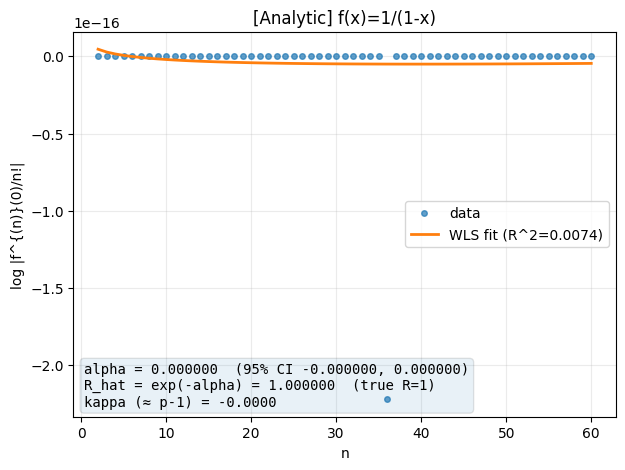

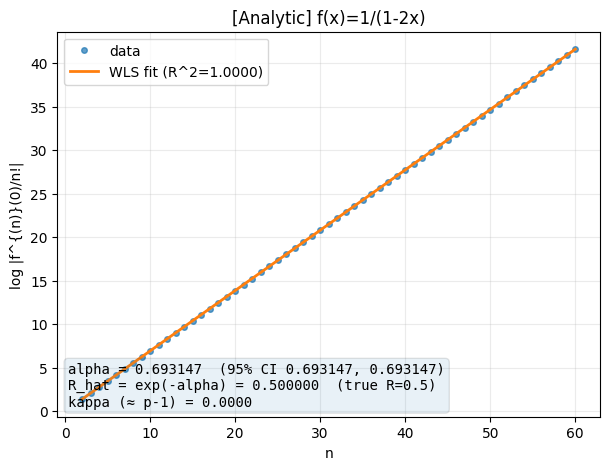

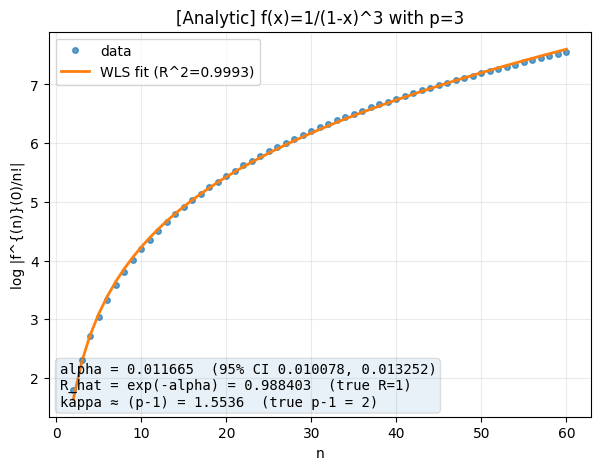


=== Analytic-case summary (R recovery) ===
f1:  R_true=1.000000,  R_hat=1.000000,  rel.err=0.000%   |  alpha=0.000000  CI=(np.float64(-9.73468946631819e-19), np.float64(1.2119020143398706e-18))
f2:  R_true=0.500000,  R_hat=0.500000,  rel.err=0.000%   |  alpha=0.693147  CI=(np.float64(0.693147180559938), np.float64(0.6931471805599413))
f3:  R_true=1.000000,  R_hat=0.988403,  rel.err=1.160%   |  alpha=0.011665  CI=(np.float64(0.010077738305389234), np.float64(0.013252098530687349))

Running Bandlimited Ω-recovery test ...


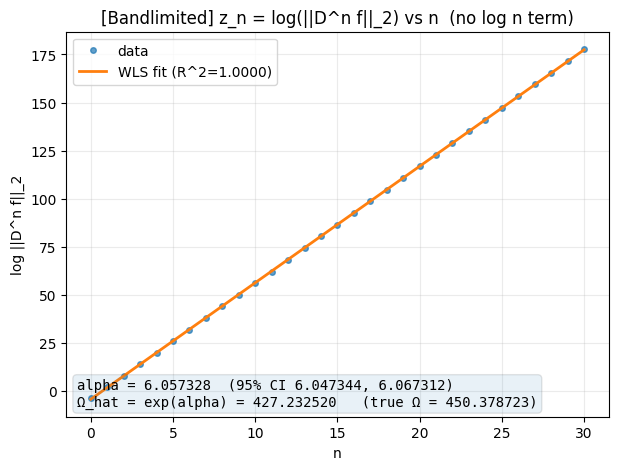

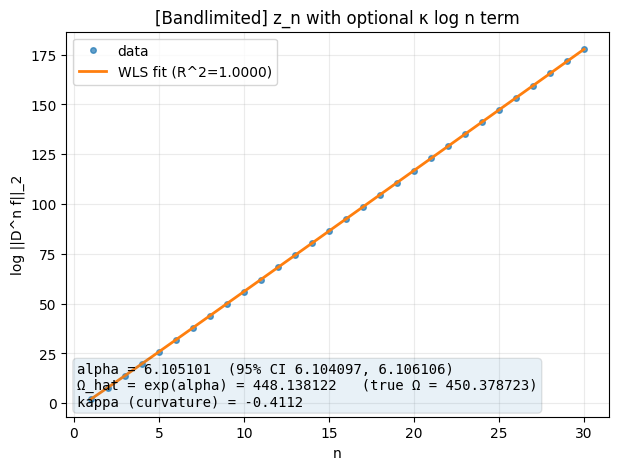


=== Bandlimited-case summary (Ω recovery) ===
Ω_true=450.378723
Model: z ~ β + α n           ->  Ω_hat=427.232520  rel.err=5.14%   CI_α=(np.float64(6.047344437740299), np.float64(6.067312379787325))
Model: z ~ β + α n + κ log n ->  Ω_hat=448.138122  rel.err=0.50%   CI_α=(np.float64(6.104097347836014), np.float64(6.106105638614807))

Running Cycle test ...
First 12 derivatives of sin at x=0: [0, 1, 0, -1, 0, 1, 0, -1, 0, 1, 0, -1]
You should see the 4-cycle: 0,1,0,-1, 0,1,0,-1, ...


In [10]:
# @title
print("Running Analytic R-recovery test ...")
analytic_test()
print("\nRunning Bandlimited Ω-recovery test ...")
bandlimited_test()
print("\nRunning Cycle test ...")
cycle_test()

We can see that in the Bandlimited case, the addition of the log(n) term strongly supports the estimation. This term likely accounts for residual non-asymptotic behavior or finite-domain effects, ensuring that the final estimate for $\lambda$ (the slope $\alpha$) is a clean measure of $\Omega$.

# Two Moons Setup

## Imports

In [11]:
import numpy as np, math, random, time
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## Repro & device

In [12]:
def set_seed(s=0):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## Data: Two Moons (+ optional label noise)

In [13]:
def make_data(n=3000, noise=0.2, label_noise=0.0, test_size=0.3, seed=0):
    X, y = make_moons(n_samples=n, noise=noise, random_state=seed)
    X = StandardScaler().fit_transform(X)
    y = y.astype(np.int64)

    if label_noise > 0:
        rng = np.random.default_rng(seed+123)
        idx = rng.choice(np.arange(n), size=int(label_noise*n), replace=False)
        y = y.copy(); y[idx] = 1 - y[idx]

    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=seed)
    return (torch.tensor(Xtr, dtype=torch.float32),
            torch.tensor(ytr, dtype=torch.long),
            torch.tensor(Xte, dtype=torch.float32),
            torch.tensor(yte, dtype=torch.long))

## Model: Smooth MLP (tanh)

In [14]:
class MLP(nn.Module):
    def __init__(self, d_in=2, d_h=64, d_h2=64, n_out=2):
        super().__init__()
        self.fc1 = nn.Linear(d_in, d_h)
        self.fc2 = nn.Linear(d_h, d_h2)
        self.fc3 = nn.Linear(d_h2, n_out)
        for m in self.modules():
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)
              if m.bias is not None:
                  nn.init.zeros_(m.bias)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return self.fc3(x)

## Helpers Functions

In [ ]:
def sample_unit_dirs(B, d):
    U = torch.randn(B, d, device=device)
    return U / (U.norm(dim=1, keepdim=True) + 1e-12)

def near_boundary_subset(model, X, band=(0.45, 0.65), fallback_k=600):
    """Return a subset of X near the decision boundary (max prob in [0.45,0.65]).
       If too few, pick the closest-to-0.5 probs."""
    model.eval()
    with torch.no_grad():

        # get the prob distribution
        logits = model(X.to(device))
        probs = torch.softmax(logits, dim=1)
        pmax = probs.max(dim=1).values

        # in between the band we set
        mask = (pmax >= band[0]) & (pmax <= band[1])
        indices = torch.where(mask)[0].cpu()
        Xb = X[indices]

        if Xb.numel() == 0:
            # fallback: choose closest to 0.5
            diffs = (pmax - 0.5).abs().cpu().numpy()
            idx = np.argsort(diffs)[:min(fallback_k, len(diffs))]
            indices = torch.from_numpy(idx)
            Xb = X[indices]

    return Xb, indices.cpu()

## nth directional derivatives of the CROSS-ENTROPY loss

In [ ]:
def nth_dir_derivs_loss(model, X, y, U, n_max=4):
    """
    X: (B,d), y: (B,), U: (B,d) unit directions
    Returns list [d1,...,d_nmax], each (B,) of D^n loss [u,...,u].
    We use sum over per-sample losses to get correct per-sample grads w.r.t. X.
    """

    #Because we're not doing any parameter updating, just analysis
    X = X.clone().detach().to(device).requires_grad_(True)
    y = y.clone().detach().to(device)
    U = U.clone().detach().to(device)

    # Sample of input data to predictions
    logits = model(X)

    # Cross entropy loss of the sample's predictions and real outputs
    # Reduction none so we can create our own scalar since we'll be repeatedly differentiating
    loss_i = F.cross_entropy(logits, y, reduction='none')

    # Turning the vector of losses (each input has it's own loss) into a scalar by summing
    y_scalar = loss_i.sum()

    out = []

    for _ in range(1, n_max+1):
        # Compute our derivative matrix
        grads = torch.autograd.grad(y_scalar, X, create_graph=True, retain_graph=True)[0]

        # Project each sample onto our directional vector and sum for overall nth derivative
        # Creates a vector of scalars for each sample
        d_n = (grads * U).sum(dim=1)

        # Append to our derivative array
        out.append(d_n.clone())

        # Collapses the scalars of each sample into a unified scalar so we can compute the next derivative
        y_scalar = d_n.sum()
    return out

def estimate_lambda_loss(model, X_eval, y_eval, n_max=4, K_dirs=2, batch=64):
    """Estimate λ on CROSS-ENTROPY, near boundary (call with X_eval already filtered)."""
    # Not training, but we want the gradient for analysis
    model.eval()
    eps = 1e-12
    logs = [[] for _ in range(n_max)]
    with torch.enable_grad():

        N = X_eval.shape[0]

        # Process eval data in batches
        for start in range(0, N, batch):
            sl = slice(start, min(start+batch, N))
            Xb = X_eval[sl]

            # only do the forward pass when you actually need predicted labels
            if y_eval is not None:
                yb_true = y_eval[sl]
            else:
                with torch.no_grad():
                    yb_true = model(Xb.to(device)).argmax(dim=1).cpu()

            # for each directin, create a unit vector
            B = Xb.shape[0]
            for _ in range(K_dirs):
                U = sample_unit_dirs(B, Xb.shape[1])

                # Receives the nth derivative list from the nth_dir_derivs_loss() function
                d_list = nth_dir_derivs_loss(model, Xb, yb_true, U, n_max=n_max)

                for n, d_n in enumerate(d_list):
                    logs[n].append(torch.log(torch.clamp(d_n.abs(), min=eps)).detach().cpu())

    # consolidate the directions
    y = np.array([torch.cat(logs[n]).mean().item() for n in range(n_max)])  # (n_max,)

    # derivative orders (n = [1, 2, 3, ... n])
    ns = np.arange(1, n_max+1, dtype=float)

    # line of best fit
    A = np.column_stack([np.ones_like(ns), ns])
    beta, alpha = np.linalg.lstsq(A, y, rcond=None)[0]

    return float(alpha), (ns, y, beta)

## λ-regularizer: penalize 2nd..N reg directional derivatives of LOSS

In [ ]:
def lambda_regularizer_loss(model, X_reg, y_reg, Nreg=3, K_dirs=2, scale=3e-3):

    X_reg = X_reg.to(device).requires_grad_(True)
    y_reg = y_reg.to(device)

    reg_terms = []

    # build graph through loss
    logits = model(X_reg)
    loss_i = F.cross_entropy(logits, y_reg, reduction='none')
    y_scalar = loss_i.sum()

    # Repeated higher order derivative tensor calculation in the direction of the U vector
    for n in range(1, Nreg+1):
        grads = torch.autograd.grad(y_scalar, X_reg, create_graph=True, retain_graph=True)[0]
        U = sample_unit_dirs(X_reg.size(0), X_reg.size(1))
        d_n = (grads * U).sum(dim=1)
        if n >= 2:
            reg_terms.append(d_n.abs().mean())
        y_scalar = d_n.sum()

    return scale * (torch.stack(reg_terms).mean() if reg_terms else torch.tensor(0.0, device=device))

## Train/eval with optional λ-regularization

In [ ]:
def train_model(Xtr, ytr, Xte, yte, seed=0, epochs=25, lambda_reg=False,
                lambda_scale=3e-3, Nreg=3, lr=1e-2, batch_size=128, weight_decay=0.0):

    set_seed(seed)

    model = MLP().to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    dl_tr = DataLoader(TensorDataset(Xtr, ytr), batch_size=batch_size, shuffle=True)
    dl_te = DataLoader(TensorDataset(Xte, yte), batch_size=512, shuffle=False)

    for _ in range(epochs):
        model.train()

        for Xb, yb in dl_tr:
            Xb = Xb.to(device)
            yb = yb.to(device)
            opt.zero_grad()

            logits = model(Xb)
            loss = F.cross_entropy(logits, yb)

            if lambda_reg:
                # small subset for reg to bound cost
                if Xb.size(0) > 64:
                    sel = torch.randperm(Xb.size(0))[:64]
                    Xreg, yreg = Xb[sel].detach(), yb[sel].detach()
                else:
                    Xreg, yreg = Xb.detach(), yb.detach()

                lreg = lambda_regularizer_loss(model, Xreg, yreg, Nreg=Nreg, K_dirs=2, scale=lambda_scale)
                loss = loss + lreg

            loss.backward()
            opt.step()

    # test accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in dl_te:
            pred = model(Xb.to(device)).argmax(dim=1).cpu()
            correct += (pred == yb).sum().item()
            total += yb.numel()

    test_accuracy = correct / total
    return model, test_accuracy

# MLP Experiments

Comprehensive Robustness Tests for Derivative Dynamics

Runs multiple experiments to validate the core claims with statistical rigor

### Helper Classes

In [ ]:
from scipy.stats import spearmanr
from scipy.stats import permutation_test
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import pandas as pd

# ============================================================================
# Helper Classes for Results Storage
# ============================================================================

@dataclass
class RobustnessResult:
    """Store results from a single experimental run"""
    label_noise: float
    lambda_scale: float
    seed: int
    test_error: float
    lambda_est: float
    test_acc: float
    config: Dict  # store any additional config params

@dataclass
class AggregatedResults:
    """Store aggregated statistics across multiple seeds"""
    condition: str
    mean_test_error: float
    ci_test_error: Tuple[float, float]
    mean_lambda: float
    ci_lambda: Tuple[float, float]
    n_seeds: int
    pearson_r: float
    pearson_p: float
    spearman_r: float
    spearman_p: float

### Experiment 1 & 6 - Multi-Seed


In [ ]:
def run_multiseed_experiment(
    label_noise: float,
    lambda_scale: float,
    n_seeds: int = 30,
    epochs: int = 25,
    band: Tuple[float, float] = (0.45, 0.65),
    K_dirs: int = 2,
    n_max: int = 4,
    verbose: bool = True
) -> List[RobustnessResult]:
    """
    Run experiment across multiple seeds for statistical robustness.

    Returns list of RobustnessResult objects, one per seed.
    """
    results = []

    if verbose:
        print(f"\n{'='*70}")
        print(f"Running {n_seeds} seeds: label_noise={label_noise:.2f}, λ_scale={lambda_scale:.4f}")
        print(f"{'='*70}")

    for i in range(n_seeds):
        seed = 42 + i

        # Generate data
        Xtr, ytr, Xte, yte = make_data(n=3000, noise=0.2, label_noise=label_noise, test_size=0.3, seed=seed)

        # Train model
        model, test_acc = train_model(
            Xtr, ytr, Xte, yte,
            seed=seed+1000,
            epochs=epochs,
            lambda_reg=(lambda_scale > 0),
            lambda_scale=lambda_scale,
            Nreg=3
        )

        # Get boundary samples
        Xnb, indices_nb = near_boundary_subset(model, Xte, band=band, fallback_k=600)

        # Estimate λ
        lambda_est, _ = estimate_lambda_loss(model, Xnb, yte[indices_nb], n_max=n_max, K_dirs=K_dirs, batch=64)

        result = RobustnessResult(
            label_noise=label_noise,
            lambda_scale=lambda_scale,
            seed=seed,
            test_error=1.0 - test_acc,
            lambda_est=lambda_est,
            test_acc=test_acc,
            config={'band': band, 'K_dirs': K_dirs, 'n_max': n_max}
        )
        results.append(result)

        if verbose and (i+1) % 10 == 0:
            print(f"  Completed {i+1}/{n_seeds} seeds")

    return results

def aggregate_results(results: List[RobustnessResult]) -> AggregatedResults:
    """Compute mean, 95% CI, and correlations from multiple seeds"""

    test_errors = np.array([r.test_error for r in results])
    lambdas = np.array([r.lambda_est for r in results])

    # Compute means and 95% CIs
    mean_te = test_errors.mean()
    ci_te = (np.percentile(test_errors, 2.5), np.percentile(test_errors, 97.5))

    mean_lam = lambdas.mean()
    ci_lam = (np.percentile(lambdas, 2.5), np.percentile(lambdas, 97.5))

    # Correlations
    pearson_r, pearson_p = pearsonr(test_errors, lambdas)
    spearman_r, spearman_p = spearmanr(test_errors, lambdas)

    condition = f"noise={results[0].label_noise:.2f}_scale={results[0].lambda_scale:.4f}"

    return AggregatedResults(
        condition=condition,
        mean_test_error=mean_te,
        ci_test_error=ci_te,
        mean_lambda=mean_lam,
        ci_lambda=ci_lam,
        n_seeds=len(results),
        pearson_r=pearson_r,
        pearson_p=pearson_p,
        spearman_r=spearman_r,
        spearman_p=spearman_p
    )

def permutation_correlation_test(test_errors: np.ndarray, lambdas: np.ndarray, n_permutations: int = 10000) -> float:
    """
    Compute permutation test p-value for correlation.
    More robust than parametric tests for small samples.
    """
    def statistic(x, y):
        return pearsonr(x, y)[0]

    # Use scipy's permutation_test
    res = permutation_test(
        (test_errors, lambdas),
        statistic,
        n_resamples=n_permutations,
        vectorized=False,
        alternative='two-sided',
        random_state=123
    )

    return res.pvalue


### Experiment 2 - Hyperparameter Ablation

In [ ]:
def hyperparam_ablation(label_noise: float = 0.3, n_seeds: int = 15, verbose: bool = True) -> pd.DataFrame:
    """
    Test stability of λ estimates across different hyperparameters.

    Varies: band width, K_dirs, n_max
    """

    configs = [
        # Vary band
        {'band': (0.48, 0.52), 'K_dirs': 2, 'n_max': 4, 'name': 'tight_band'},
        {'band': (0.45, 0.65), 'K_dirs': 2, 'n_max': 4, 'name': 'medium_band'},
        {'band': (0.40, 0.70), 'K_dirs': 2, 'n_max': 4, 'name': 'wide_band'},

        # Vary K_dirs
        {'band': (0.45, 0.65), 'K_dirs': 2, 'n_max': 4, 'name': 'K_dirs=2'},
        {'band': (0.45, 0.65), 'K_dirs': 4, 'n_max': 4, 'name': 'K_dirs=4'},
        {'band': (0.45, 0.65), 'K_dirs': 8, 'n_max': 4, 'name': 'K_dirs=8'},

        # Vary n_max
        {'band': (0.45, 0.65), 'K_dirs': 2, 'n_max': 3, 'name': 'n_max=3'},
        {'band': (0.45, 0.65), 'K_dirs': 2, 'n_max': 4, 'name': 'n_max=4'},
        {'band': (0.45, 0.65), 'K_dirs': 2, 'n_max': 5, 'name': 'n_max=5'},
    ]

    results_df = []

    for cfg in configs:
        if verbose:
            print(f"\n--- Testing config: {cfg['name']} ---")

        results = run_multiseed_experiment(
            label_noise=label_noise,
            lambda_scale=0.0,  # baseline, no regularization
            n_seeds=n_seeds,
            band=cfg['band'],
            K_dirs=cfg['K_dirs'],
            n_max=cfg['n_max'],
            verbose=False
        )

        agg = aggregate_results(results)

        results_df.append({
            'config_name': cfg['name'],
            'band': str(cfg['band']),
            'K_dirs': cfg['K_dirs'],
            'n_max': cfg['n_max'],
            'mean_lambda': agg.mean_lambda,
            'lambda_ci_lower': agg.ci_lambda[0],
            'lambda_ci_upper': agg.ci_lambda[1],
            'lambda_ci_width': agg.ci_lambda[1] - agg.ci_lambda[0],
            'mean_test_error': agg.mean_test_error
        })

        if verbose:
            print(f"  λ = {agg.mean_lambda:.4f} [{agg.ci_lambda[0]:.4f}, {agg.ci_lambda[1]:.4f}]")

    return pd.DataFrame(results_df)


### Experiment 3 - Boundary Selection: True vs Predicted Labels

In [ ]:
def boundary_label_comparison(label_noise: float = 0.3, n_seeds: int = 20) -> Dict:
    """
    Compare λ estimates using true labels vs predicted labels.
    Tests whether label noise confounds are properly controlled.
    """

    results_true, results_pred = [], []

    print(f"\n{'='*70}")
    print(f"Boundary Label Comparison: label_noise={label_noise:.2f}")
    print(f"{'='*70}")

    for i in range(n_seeds):
        seed = 42 + i

        Xtr, ytr, Xte, yte = make_data(n=3000, noise=0.2, label_noise=label_noise, seed=seed)

        model, test_acc = train_model(Xtr, ytr, Xte, yte, seed=seed+1000, epochs=25, lambda_reg=False)

        Xnb, indices_nb = near_boundary_subset(model, Xte, band=(0.45, 0.65), fallback_k=600)

        # True labels
        lambda_true, _ = estimate_lambda_loss(model, Xnb, yte[indices_nb], n_max=4, K_dirs=2, batch=64)

        # Predicted labels
        with torch.no_grad():
            ypred = model(Xnb.to(device)).argmax(dim=1).cpu()

        lambda_pred, _ = estimate_lambda_loss(model, Xnb, ypred, n_max=4, K_dirs=2, batch=64)

        results_true.append(lambda_true)
        results_pred.append(lambda_pred)

        if (i+1) % 5 == 0:
            print(f"  Completed {i+1}/{n_seeds} seeds")

    results_true = np.array(results_true)
    results_pred = np.array(results_pred)

    # Correlation between the two methods
    corr, _ = pearsonr(results_true, results_pred)

    return {
        'lambda_true': results_true,
        'lambda_pred': results_pred,
        'mean_true': results_true.mean(),
        'mean_pred': results_pred.mean(),
        'correlation': corr,
        'mean_absolute_diff': np.abs(results_true - results_pred).mean()
    }

### Experiment 4 - Loss-Centric vs Logit-Centric λ

In [ ]:
def estimate_lambda_logit(model, X_eval, n_max=4, K_dirs=2, batch=64):
    """
    Estimate λ on TOP LOGIT (not loss).
    Similar to estimate_lambda_loss but tracks f(x) = max logit.
    """
    model.eval()
    eps = 1e-12
    logs = [[] for _ in range(n_max)]

    with torch.enable_grad():
        N = X_eval.shape[0]

        for start in range(0, N, batch):
            sl = slice(start, min(start+batch, N))
            Xb = X_eval[sl].clone().detach().to(device).requires_grad_(True)

            B = Xb.shape[0]

            for _ in range(K_dirs):
                U = sample_unit_dirs(B, Xb.shape[1])

                # Get top logit as the scalar output
                logits = model(Xb)
                y_scalar = logits.max(dim=1).values.sum()

                # Compute derivatives
                for n in range(1, n_max+1):
                    grads = torch.autograd.grad(y_scalar, Xb, create_graph=True, retain_graph=True)[0]
                    d_n = (grads * U).sum(dim=1)
                    logs[n-1].append(torch.log(torch.clamp(d_n.abs(), min=eps)).detach().cpu())
                    y_scalar = d_n.sum()

    y = np.array([torch.cat(logs[n]).mean().item() for n in range(n_max)])
    ns = np.arange(1, n_max+1, dtype=float)
    A = np.column_stack([np.ones_like(ns), ns])
    beta, alpha = np.linalg.lstsq(A, y, rcond=None)[0]

    return float(alpha), (ns, y, beta)

def loss_vs_logit_comparison(label_noise: float = 0.3, n_seeds: int = 20) -> Dict:
    """
    Compare λ estimates from loss-centric vs logit-centric measurements.
    """

    results_loss, results_logit = [], []

    print(f"\n{'='*70}")
    print(f"Loss vs Logit Comparison: label_noise={label_noise:.2f}")
    print(f"{'='*70}")

    for i in range(n_seeds):
        seed = 42 + i

        Xtr, ytr, Xte, yte = make_data(
            n=3000, noise=0.2, label_noise=label_noise, seed=seed
        )

        model, _ = train_model(
            Xtr, ytr, Xte, yte, seed=seed+1000,
            epochs=25, lambda_reg=False
        )

        Xnb, indices_nb = near_boundary_subset(model, Xte, band=(0.45, 0.65), fallback_k=600)

        # Loss-centric
        lambda_loss, _ = estimate_lambda_loss(
            model, Xnb, yte[indices_nb], n_max=4, K_dirs=2, batch=64
        )

        # Logit-centric
        lambda_logit, _ = estimate_lambda_logit(
            model, Xnb, n_max=4, K_dirs=2, batch=64
        )

        results_loss.append(lambda_loss)
        results_logit.append(lambda_logit)

        if (i+1) % 5 == 0:
            print(f"  Completed {i+1}/{n_seeds} seeds")

    results_loss = np.array(results_loss)
    results_logit = np.array(results_logit)

    corr, _ = pearsonr(results_loss, results_logit)

    return {
        'lambda_loss': results_loss,
        'lambda_logit': results_logit,
        'mean_loss': results_loss.mean(),
        'mean_logit': results_logit.mean(),
        'correlation': corr
    }


### Experiment 5 - Training Dynamics: λ Over Epochs

In [ ]:
def track_lambda_dynamics(
    label_noise: float = 0.3,
    lambda_scale: float = 3e-3,
    epochs: int = 50,
    track_every: int = 5,
    seed: int = 42
) -> Tuple[List, List]:
    """
    Track λ and test error over training epochs.
    Returns two lists: one for baseline, one for λ-regularized.
    """

    print(f"\n{'='*70}")
    print(f"Training Dynamics: tracking λ over {epochs} epochs")
    print(f"{'='*70}")

    def train_and_track(use_reg: bool):
        set_seed(seed)
        Xtr, ytr, Xte, yte = make_data(n=3000, noise=0.2, label_noise=label_noise, seed=seed)

        model = MLP().to(device)
        opt = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
        dl_tr = DataLoader(TensorDataset(Xtr, ytr), batch_size=128, shuffle=True)
        dl_te = DataLoader(TensorDataset(Xte, yte), batch_size=512, shuffle=False)

        history = []

        for ep in range(epochs):
            # Train one epoch
            model.train()
            for Xb, yb in dl_tr:
                Xb, yb = Xb.to(device), yb.to(device)
                opt.zero_grad()
                logits = model(Xb)
                loss = F.cross_entropy(logits, yb)

                if use_reg:
                    sel = torch.randperm(Xb.size(0))[:64] if Xb.size(0) > 64 else slice(None)
                    Xreg = Xb[sel].detach() if isinstance(sel, torch.Tensor) else Xb.detach()
                    yreg = yb[sel].detach() if isinstance(sel, torch.Tensor) else yb.detach()
                    lreg = lambda_regularizer_loss(model, Xreg, yreg, Nreg=3, K_dirs=2, scale=lambda_scale)
                    loss = loss + lreg

                loss.backward()
                opt.step()

            # Track every N epochs
            if (ep + 1) % track_every == 0 or ep == 0:
                model.eval()
                correct, total = 0, 0
                with torch.no_grad():
                    for Xb, yb in dl_te:
                        pred = model(Xb.to(device)).argmax(dim=1).cpu()
                        correct += (pred == yb).sum().item()
                        total += yb.numel()
                test_acc = correct / total

                Xnb, indices_nb = near_boundary_subset(model, Xte, band=(0.45, 0.65), fallback_k=600)
                lambda_est, _ = estimate_lambda_loss(model, Xnb, yte[indices_nb], n_max=4, K_dirs=2, batch=64)

                history.append({
                    'epoch': ep + 1,
                    'test_error': 1.0 - test_acc,
                    'lambda': lambda_est,
                    'regularized': use_reg
                })

                print(f"  Epoch {ep+1:3d}: test_err={1.0-test_acc:.4f}, λ={lambda_est:.4f} {'[REG]' if use_reg else '[BASE]'}")

        return history

    baseline_history = train_and_track(use_reg=False)
    regularized_history = train_and_track(use_reg=True)

    return baseline_history, regularized_history


### Experiment 7 - Effect Size Analysis

In [ ]:
def effect_size_analysis(results: List[RobustnessResult]) -> Dict:
    """
    Compute effect size: Δ(test_error) per unit Δλ.
    Fits simple linear model: test_error ~ β₀ + β₁ * λ
    """

    test_errors = np.array([r.test_error for r in results])
    lambdas = np.array([r.lambda_est for r in results])

    # Simple linear regression
    X = np.column_stack([np.ones_like(lambdas), lambdas])
    beta, _, _, _ = np.linalg.lstsq(X, test_errors, rcond=None)

    # Bootstrap for CI on slope
    n_boot = 1000
    slopes = []
    for _ in range(n_boot):
        idx = np.random.choice(len(test_errors), size=len(test_errors), replace=True)
        X_boot = np.column_stack([np.ones(len(idx)), lambdas[idx]])
        beta_boot, _, _, _ = np.linalg.lstsq(X_boot, test_errors[idx], rcond=None)
        slopes.append(beta_boot[1])

    slopes = np.array(slopes)
    ci_slope = (np.percentile(slopes, 2.5), np.percentile(slopes, 97.5))

    return {
        'slope': beta[1],  # Δerror per unit Δλ
        'intercept': beta[0],
        'ci_slope': ci_slope,
        'mean_slope': slopes.mean(),
        'std_slope': slopes.std()
    }

### Plotting Functions

In [ ]:
def plot_robustness_results(all_results: Dict):
    """Generate comprehensive plots for all robustness tests"""

    # 1. Correlation plot with error bars
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Extract correlation data
    corr_data = all_results['correlation']
    noise_levels = sorted(set(r.label_noise for r in corr_data))

    for noise in noise_levels:
        subset = [r for r in corr_data if r.label_noise == noise]
        te = np.array([r.test_error for r in subset])
        lam = np.array([r.lambda_est for r in subset])

        axes[0, 0].scatter(lam, te, alpha=0.5, label=f'noise={noise:.2f}', s=30)

    axes[0, 0].set_xlabel('λ estimate')
    axes[0, 0].set_ylabel('Test Error')
    axes[0, 0].set_title('Test Error vs λ (all seeds & conditions)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Ablation results
    abl = all_results['ablation']
    x_pos = np.arange(len(abl))
    axes[0, 1].errorbar(
        x_pos, abl['mean_lambda'],
        yerr=[abl['mean_lambda'] - abl['lambda_ci_lower'],
              abl['lambda_ci_upper'] - abl['mean_lambda']],
        fmt='o', capsize=5, capthick=2
    )
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels(abl['config_name'], rotation=45, ha='right')
    axes[0, 1].set_ylabel('λ estimate')
    axes[0, 1].set_title('Hyperparameter Ablation: λ Stability')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Training dynamics
    dyn = all_results['dynamics']
    base_df = pd.DataFrame(dyn['baseline'])
    reg_df = pd.DataFrame(dyn['regularized'])

    ax3a = axes[1, 0]
    ax3b = ax3a.twinx()

    ax3a.plot(base_df['epoch'], base_df['lambda'], 'o-', label='λ (baseline)', color='C0')
    ax3a.plot(reg_df['epoch'], reg_df['lambda'], 's-', label='λ (regularized)', color='C1')
    ax3b.plot(base_df['epoch'], base_df['test_error'], 'o--', label='error (baseline)', color='C0', alpha=0.5)
    ax3b.plot(reg_df['epoch'], reg_df['test_error'], 's--', label='error (regularized)', color='C1', alpha=0.5)

    ax3a.set_xlabel('Epoch')
    ax3a.set_ylabel('λ estimate', color='black')
    ax3b.set_ylabel('Test Error', color='gray')
    ax3a.set_title('Training Dynamics: λ and Error Over Time')
    ax3a.legend(loc='upper left')
    ax3b.legend(loc='upper right')
    ax3a.grid(True, alpha=0.3)

    # 4. Sweep results
    sweep = pd.DataFrame(all_results['sweep'])
    axes[1, 1].errorbar(
        sweep['scale'], sweep['mean_test_error'],
        yerr=[sweep['mean_test_error'] - [ci[0] for ci in sweep['ci_test_error']],
              [ci[1] for ci in sweep['ci_test_error']] - sweep['mean_test_error']],
        fmt='o-', capsize=5, capthick=2
    )
    axes[1, 1].set_xlabel('λ-regularization scale')
    axes[1, 1].set_ylabel('Test Error')
    axes[1, 1].set_title('Regularization Sweep (with 95% CI)')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Additional comparison plots
    fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))

    # Boundary comparison
    bc = all_results['boundary_comparison']
    axes2[0].scatter(bc['lambda_true'], bc['lambda_pred'], alpha=0.6)
    min_val = min(bc['lambda_true'].min(), bc['lambda_pred'].min())
    max_val = max(bc['lambda_true'].max(), bc['lambda_pred'].max())
    axes2[0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
    axes2[0].set_xlabel('λ (true labels)')
    axes2[0].set_ylabel('λ (predicted labels)')
    axes2[0].set_title(f'Boundary Selection\n(r={bc["correlation"]:.3f})')
    axes2[0].grid(True, alpha=0.3)

    # Loss vs Logit
    llc = all_results['loss_vs_logit']
    axes2[1].scatter(llc['lambda_loss'], llc['lambda_logit'], alpha=0.6, color='C2')
    min_val = min(llc['lambda_loss'].min(), llc['lambda_logit'].min())
    max_val = max(llc['lambda_loss'].max(), llc['lambda_logit'].max())
    axes2[1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
    axes2[1].set_xlabel('λ (loss-centric)')
    axes2[1].set_ylabel('λ (logit-centric)')
    axes2[1].set_title(f'Loss vs Logit Measurement\n(r={llc["correlation"]:.3f})')
    axes2[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### Experiment Orchestrator

In [ ]:
def run_full_robustness_suite(
    n_seeds_main: int = 30,
    n_seeds_ablation: int = 15,
    n_seeds_comparison: int = 20,
    save_results: bool = True
):
    print("\n" + "="*70)
    print("COMPREHENSIVE ROBUSTNESS TEST SUITE")
    print("="*70)

    all_results = {}

    # ========== 1. Multi-seed correlation test ==========
    print("\n\n[1/7] Multi-seed correlation experiments...")

    conditions = [
        (0.0, 0.0),   # no noise, no reg
        (0.3, 0.0),   # medium noise, no reg
        (0.45, 0.0),  # high noise, no reg
    ]

    correlation_results = []
    for label_noise, lambda_scale in conditions:
        results = run_multiseed_experiment(
            label_noise=label_noise,
            lambda_scale=lambda_scale,
            n_seeds=n_seeds_main,
            verbose=True
        )
        agg = aggregate_results(results)
        correlation_results.extend(results)

        # Permutation test
        test_errors = np.array([r.test_error for r in results])
        lambdas = np.array([r.lambda_est for r in results])
        perm_p = permutation_correlation_test(test_errors, lambdas)

        print(f"\n  Condition: {agg.condition}")
        print(f"    Test Error: {agg.mean_test_error:.4f} [{agg.ci_test_error[0]:.4f}, {agg.ci_test_error[1]:.4f}]")
        print(f"    λ:          {agg.mean_lambda:.4f} [{agg.ci_lambda[0]:.4f}, {agg.ci_lambda[1]:.4f}]")
        print(f"    Pearson:    r={agg.pearson_r:.3f}, p={agg.pearson_p:.3g}")
        print(f"    Spearman:   r={agg.spearman_r:.3f}, p={agg.spearman_p:.3g}")
        print(f"    Permutation p: {perm_p:.3g}")

    all_results['correlation'] = correlation_results

    # ========== 2. Hyperparameter ablation ==========
    print("\n\n[2/7] Hyperparameter ablation...")
    ablation_df = hyperparam_ablation(
        label_noise=0.3,
        n_seeds=n_seeds_ablation,
        verbose=True
    )
    print("\n  Ablation Results:")
    print(ablation_df.to_string(index=False))
    all_results['ablation'] = ablation_df

    # ========== 3. Boundary label comparison ==========
    print("\n\n[3/7] Boundary selection: true vs predicted labels...")
    boundary_comp = boundary_label_comparison(
        label_noise=0.3,
        n_seeds=n_seeds_comparison
    )
    print(f"\n  Mean λ (true labels):  {boundary_comp['mean_true']:.4f}")
    print(f"  Mean λ (pred labels):  {boundary_comp['mean_pred']:.4f}")
    print(f"  Correlation:           {boundary_comp['correlation']:.3f}")
    print(f"  Mean Absolute Diff:    {boundary_comp['mean_absolute_diff']:.4f}")
    all_results['boundary_comparison'] = boundary_comp

    # ========== 4. Loss vs logit centric ==========
    print("\n\n[4/7] Loss-centric vs logit-centric λ...")
    loss_logit_comp = loss_vs_logit_comparison(
        label_noise=0.3,
        n_seeds=n_seeds_comparison
    )
    print(f"\n  Mean λ (loss):   {loss_logit_comp['mean_loss']:.4f}")
    print(f"  Mean λ (logit):  {loss_logit_comp['mean_logit']:.4f}")
    print(f"  Correlation:     {loss_logit_comp['correlation']:.3f}")
    all_results['loss_vs_logit'] = loss_logit_comp

    # ========== 5. Training dynamics ==========
    print("\n\n[5/7] Training dynamics over epochs...")
    baseline_hist, reg_hist = track_lambda_dynamics(
        label_noise=0.3,
        lambda_scale=3e-3,
        epochs=50,
        track_every=5,
        seed=42
    )
    all_results['dynamics'] = {'baseline': baseline_hist, 'regularized': reg_hist}

    # ========== 6. Lambda scale sweep ==========
    print("\n\n[6/7] λ-regularization scale sweep...")
    scales = [0.0, 1e-3, 2e-3, 3e-3, 5e-3, 1e-2]
    sweep_results = []
    for scale in scales:
        results = run_multiseed_experiment(
            label_noise=0.3,
            lambda_scale=scale,
            n_seeds=n_seeds_main,
            verbose=False
        )
        agg = aggregate_results(results)
        sweep_results.append({
            'scale': scale,
            'mean_test_error': agg.mean_test_error,
            'ci_test_error': agg.ci_test_error,
            'mean_lambda': agg.mean_lambda,
            'ci_lambda': agg.ci_lambda
        })
        print(f"  Scale {scale:.4f}: error={agg.mean_test_error:.4f}, λ={agg.mean_lambda:.4f}")

    all_results['sweep'] = sweep_results

    # ========== 7. Effect size analysis ==========
    print("\n\n[7/7] Effect size analysis...")
    effect_size = effect_size_analysis(correlation_results)
    print(f"\n  Δ(test_error) per unit Δλ:")
    print(f"    Slope: {effect_size['slope']:.4f}")
    print(f"    95% CI: [{effect_size['ci_slope'][0]:.4f}, {effect_size['ci_slope'][1]:.4f}]")
    all_results['effect_size'] = effect_size

    # ========== Generate plots ==========
    print("\n\n[PLOTS] Generating visualizations...")
    plot_robustness_results(all_results)

    print("\n" + "="*70)
    print("ROBUSTNESS SUITE COMPLETE")
    print("="*70)

    return all_results



COMPREHENSIVE ROBUSTNESS TEST SUITE


[1/7] Multi-seed correlation experiments...

Running 40 seeds: label_noise=0.00, λ_scale=0.0000
  Completed 10/40 seeds
  Completed 20/40 seeds
  Completed 30/40 seeds
  Completed 40/40 seeds

  Condition: noise=0.00_scale=0.0000
    Test Error: 0.0342 [0.0244, 0.0456]
    λ:          1.9773 [1.7136, 2.2738]
    Pearson:    r=-0.165, p=0.308
    Spearman:   r=-0.101, p=0.535
    Permutation p: 0.335

Running 40 seeds: label_noise=0.30, λ_scale=0.0000
  Completed 10/40 seeds
  Completed 20/40 seeds
  Completed 30/40 seeds
  Completed 40/40 seeds

  Condition: noise=0.30_scale=0.0000
    Test Error: 0.3225 [0.3053, 0.3467]
    λ:          1.5865 [1.2441, 1.8766]
    Pearson:    r=0.051, p=0.753
    Spearman:   r=0.075, p=0.646
    Permutation p: 0.739

Running 40 seeds: label_noise=0.45, λ_scale=0.0000
  Completed 10/40 seeds
  Completed 20/40 seeds
  Completed 30/40 seeds
  Completed 40/40 seeds

  Condition: noise=0.45_scale=0.0000
    Test Error:

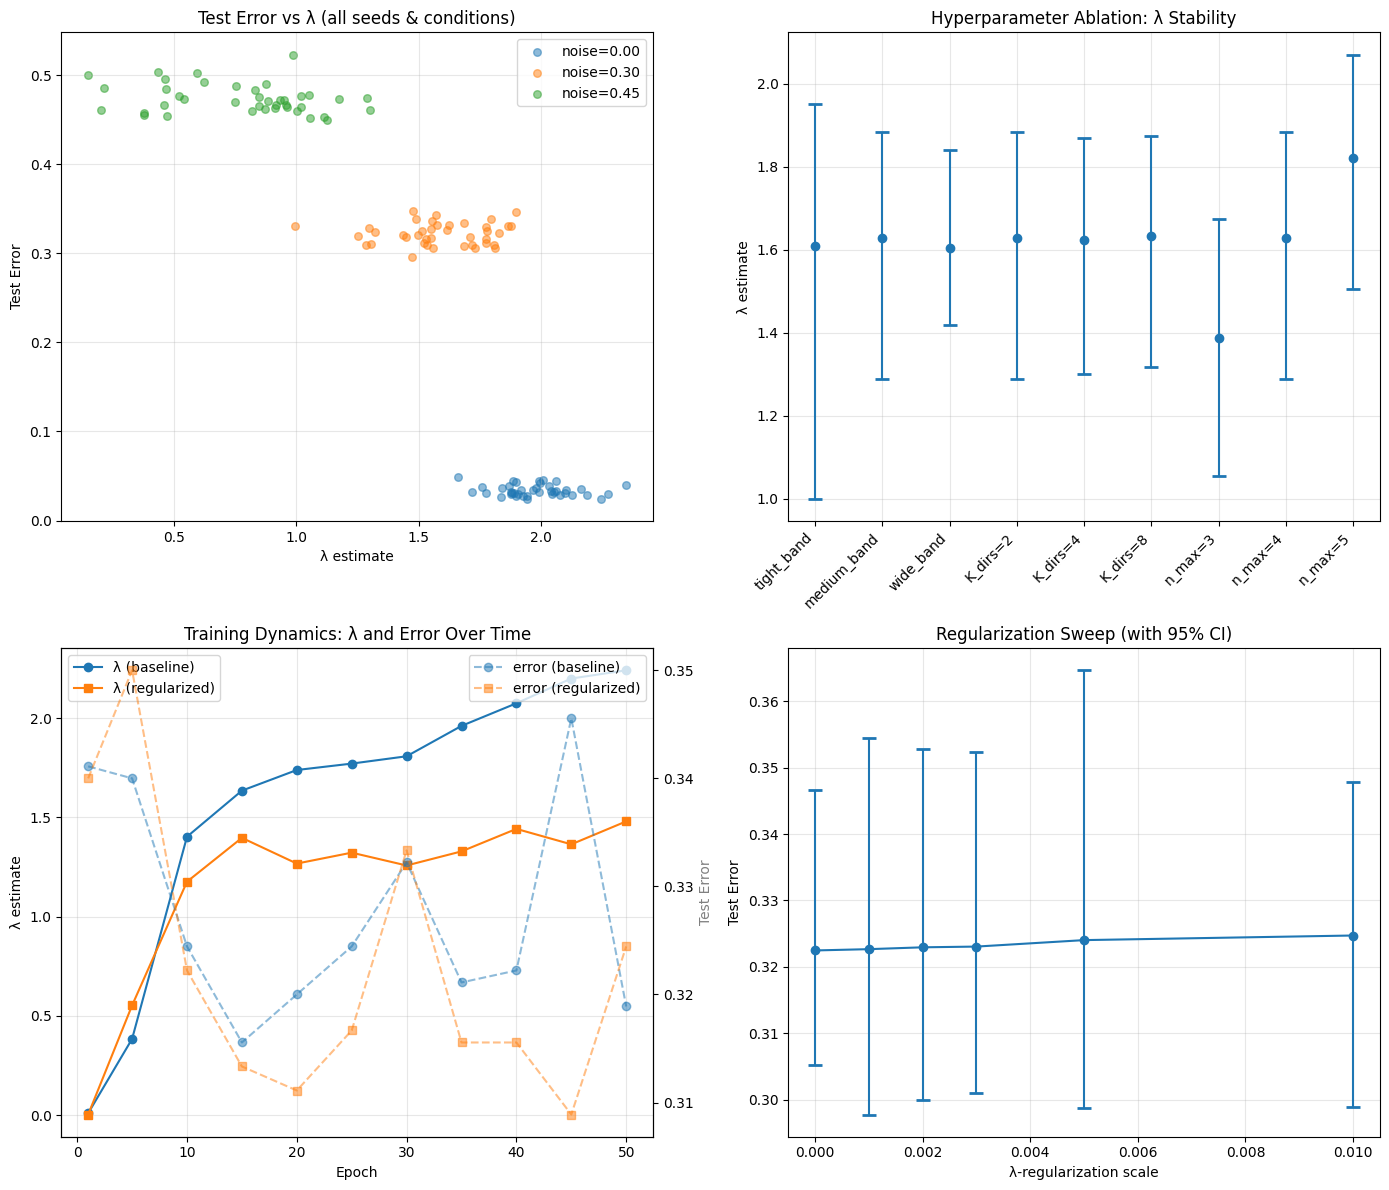

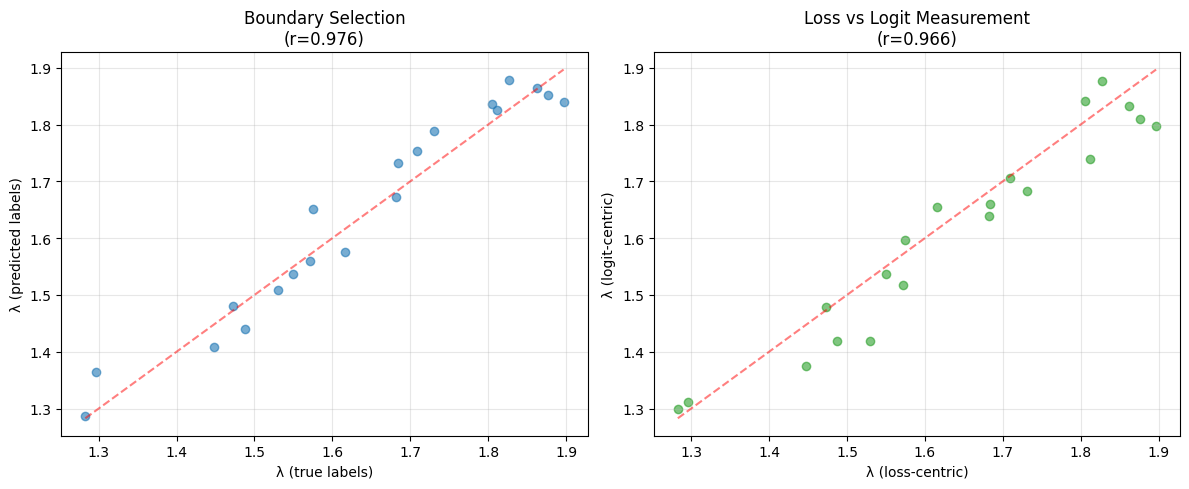


ROBUSTNESS SUITE COMPLETE


In [ ]:
results = run_full_robustness_suite(n_seeds_main=40,
                                    n_seeds_ablation=15,
                                    n_seeds_comparison=20)

### Training Dynamics Figure


RUNNING MULTI-SEED TRAINING DYNAMICS

Tracking training dynamics across 20 seeds...
Label noise: 0.3, Lambda scale: 0.003
Epochs: 50, Track every: 5 epochs

  Completed 5/20 seeds
  Completed 10/20 seeds
  Completed 15/20 seeds
  Completed 20/20 seeds


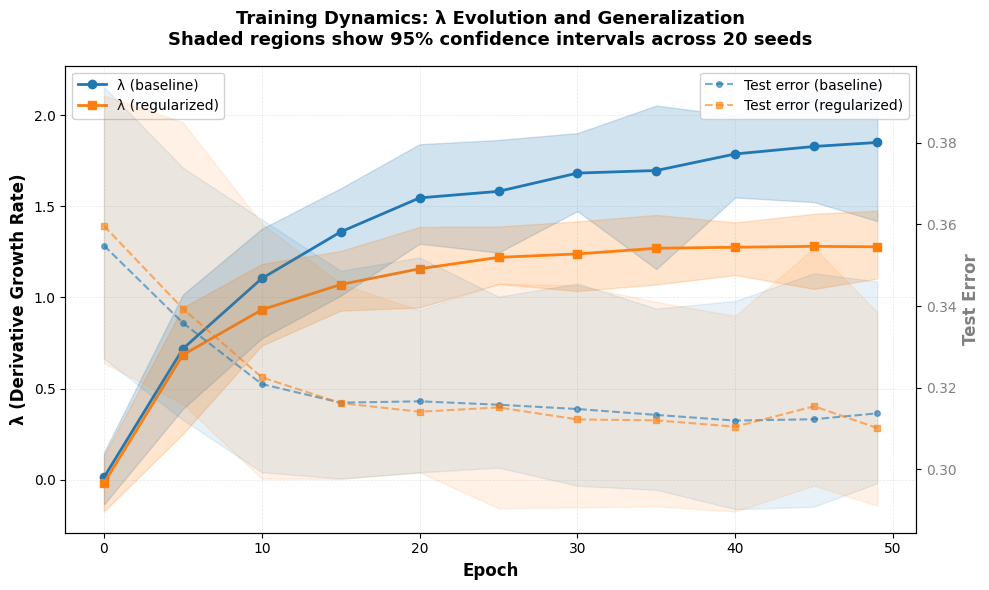


TRAINING DYNAMICS SUMMARY

Final Epoch (49):
  Baseline:
    λ = 1.850 [1.418, 2.154]
    Test Error = 0.3137 [0.2966, 0.3460]
  Regularized:
    λ = 1.277 [1.103, 1.476]
    Test Error = 0.3101 [0.2911, 0.3385]

  λ Reduction: 30.9%


In [ ]:
"""## Multi-Seed Training Dynamics with Confidence Intervals"""

def track_lambda_dynamics_multiseed(
    label_noise: float = 0.3,
    lambda_scale: float = 3e-3,
    epochs: int = 50,
    track_every: int = 5,
    n_seeds: int = 20
):
    """
    Track lambda and test error evolution across multiple seeds.
    Returns dataframes with mean and confidence intervals.
    """

    baseline_trajectories = []
    regularized_trajectories = []

    print(f"\nTracking training dynamics across {n_seeds} seeds...")
    print(f"Label noise: {label_noise}, Lambda scale: {lambda_scale}")
    print(f"Epochs: {epochs}, Track every: {track_every} epochs\n")

    for i in range(n_seeds):
        seed = 100 + i

        # Generate data
        Xtr, ytr, Xte, yte = make_data(
            n=3000, noise=0.2, label_noise=label_noise,
            test_size=0.3, seed=seed
        )

        # Track baseline (no regularization)
        baseline_history = []
        model_base = MLP().to(device)
        opt_base = torch.optim.Adam(model_base.parameters(), lr=1e-2)
        dl_tr = DataLoader(TensorDataset(Xtr, ytr), batch_size=128, shuffle=True)
        dl_te = DataLoader(TensorDataset(Xte, yte), batch_size=512, shuffle=False)

        set_seed(seed + 5000)

        for epoch in range(epochs):
            # Train
            model_base.train()
            for Xb, yb in dl_tr:
                Xb, yb = Xb.to(device), yb.to(device)
                opt_base.zero_grad()
                loss = F.cross_entropy(model_base(Xb), yb)
                loss.backward()
                opt_base.step()

            # Evaluate at tracking epochs
            if epoch % track_every == 0 or epoch == epochs - 1:
                model_base.eval()
                correct, total = 0, 0
                with torch.no_grad():
                    for Xb, yb in dl_te:
                        pred = model_base(Xb.to(device)).argmax(dim=1).cpu()
                        correct += (pred == yb).sum().item()
                        total += yb.numel()
                test_acc = correct / total
                test_err = 1.0 - test_acc

                # Measure lambda
                Xnb, indices_nb = near_boundary_subset(
                    model_base, Xte, band=(0.45, 0.65), fallback_k=600
                )
                lam, _ = estimate_lambda_loss(
                    model_base, Xnb, yte[indices_nb],
                    n_max=4, K_dirs=2, batch=64
                )

                baseline_history.append({
                    'epoch': epoch,
                    'lambda': lam,
                    'test_error': test_err,
                    'seed': seed
                })

        # Track regularized
        regularized_history = []
        model_reg = MLP().to(device)
        opt_reg = torch.optim.Adam(model_reg.parameters(), lr=1e-2)

        set_seed(seed + 10000)

        for epoch in range(epochs):
            # Train with regularization
            model_reg.train()
            for Xb, yb in dl_tr:
                Xb, yb = Xb.to(device), yb.to(device)
                opt_reg.zero_grad()
                loss = F.cross_entropy(model_reg(Xb), yb)

                # Add lambda regularization
                if Xb.size(0) > 64:
                    sel = torch.randperm(Xb.size(0))[:64]
                    Xreg, yreg = Xb[sel].detach(), yb[sel].detach()
                else:
                    Xreg, yreg = Xb.detach(), yb.detach()

                lreg = lambda_regularizer_loss(
                    model_reg, Xreg, yreg, Nreg=3, K_dirs=2, scale=lambda_scale
                )
                loss = loss + lreg

                loss.backward()
                opt_reg.step()

            # Evaluate at tracking epochs
            if epoch % track_every == 0 or epoch == epochs - 1:
                model_reg.eval()
                correct, total = 0, 0
                with torch.no_grad():
                    for Xb, yb in dl_te:
                        pred = model_reg(Xb.to(device)).argmax(dim=1).cpu()
                        correct += (pred == yb).sum().item()
                        total += yb.numel()
                test_acc = correct / total
                test_err = 1.0 - test_acc

                # Measure lambda
                Xnb, indices_nb = near_boundary_subset(
                    model_reg, Xte, band=(0.45, 0.65), fallback_k=600
                )
                lam, _ = estimate_lambda_loss(
                    model_reg, Xnb, yte[indices_nb],
                    n_max=4, K_dirs=2, batch=64
                )

                regularized_history.append({
                    'epoch': epoch,
                    'lambda': lam,
                    'test_error': test_err,
                    'seed': seed
                })

        baseline_trajectories.extend(baseline_history)
        regularized_trajectories.extend(regularized_history)

        if (i + 1) % 5 == 0:
            print(f"  Completed {i+1}/{n_seeds} seeds")

    # Convert to dataframes
    baseline_df = pd.DataFrame(baseline_trajectories)
    regularized_df = pd.DataFrame(regularized_trajectories)

    return baseline_df, regularized_df


def plot_multiseed_dynamics(baseline_df, regularized_df):
    """
    Create a clean publication-quality plot with mean trajectories and confidence bands.
    """

    # Compute statistics for each epoch
    epochs = sorted(baseline_df['epoch'].unique())

    base_stats = []
    for epoch in epochs:
        epoch_data = baseline_df[baseline_df['epoch'] == epoch]
        base_stats.append({
            'epoch': epoch,
            'lambda_mean': epoch_data['lambda'].mean(),
            'lambda_lower': np.percentile(epoch_data['lambda'], 2.5),
            'lambda_upper': np.percentile(epoch_data['lambda'], 97.5),
            'error_mean': epoch_data['test_error'].mean(),
            'error_lower': np.percentile(epoch_data['test_error'], 2.5),
            'error_upper': np.percentile(epoch_data['test_error'], 97.5)
        })
    base_stats_df = pd.DataFrame(base_stats)

    reg_stats = []
    for epoch in epochs:
        epoch_data = regularized_df[regularized_df['epoch'] == epoch]
        reg_stats.append({
            'epoch': epoch,
            'lambda_mean': epoch_data['lambda'].mean(),
            'lambda_lower': np.percentile(epoch_data['lambda'], 2.5),
            'lambda_upper': np.percentile(epoch_data['lambda'], 97.5),
            'error_mean': epoch_data['test_error'].mean(),
            'error_lower': np.percentile(epoch_data['test_error'], 2.5),
            'error_upper': np.percentile(epoch_data['test_error'], 97.5)
        })
    reg_stats_df = pd.DataFrame(reg_stats)

    # Create figure with dual y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    # Lambda trajectories (left axis)
    ax1.plot(base_stats_df['epoch'], base_stats_df['lambda_mean'],
             'o-', color='C0', linewidth=2, markersize=6,
             label='λ (baseline)', zorder=3)
    ax1.fill_between(base_stats_df['epoch'],
                     base_stats_df['lambda_lower'],
                     base_stats_df['lambda_upper'],
                     color='C0', alpha=0.2, zorder=1)

    ax1.plot(reg_stats_df['epoch'], reg_stats_df['lambda_mean'],
             's-', color='C1', linewidth=2, markersize=6,
             label='λ (regularized)', zorder=3)
    ax1.fill_between(reg_stats_df['epoch'],
                     reg_stats_df['lambda_lower'],
                     reg_stats_df['lambda_upper'],
                     color='C1', alpha=0.2, zorder=1)

    # Test error trajectories (right axis)
    ax2.plot(base_stats_df['epoch'], base_stats_df['error_mean'],
             'o--', color='C0', linewidth=1.5, markersize=4,
             alpha=0.6, label='Test error (baseline)', zorder=2)
    ax2.fill_between(base_stats_df['epoch'],
                     base_stats_df['error_lower'],
                     base_stats_df['error_upper'],
                     color='C0', alpha=0.1, zorder=0)

    ax2.plot(reg_stats_df['epoch'], reg_stats_df['error_mean'],
             's--', color='C1', linewidth=1.5, markersize=4,
             alpha=0.6, label='Test error (regularized)', zorder=2)
    ax2.fill_between(reg_stats_df['epoch'],
                     reg_stats_df['error_lower'],
                     reg_stats_df['error_upper'],
                     color='C1', alpha=0.1, zorder=0)

    # Styling
    ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax1.set_ylabel('λ (Derivative Growth Rate)', fontsize=12,
                   fontweight='bold', color='black')
    ax2.set_ylabel('Test Error', fontsize=12, fontweight='bold', color='gray')

    ax1.tick_params(axis='y', labelcolor='black')
    ax2.tick_params(axis='y', labelcolor='gray')

    ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax1.set_axisbelow(True)

    # Legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1, labels1, loc='upper left', fontsize=10, framealpha=0.9)
    ax2.legend(lines2, labels2, loc='upper right', fontsize=10, framealpha=0.9)

    plt.title('Training Dynamics: λ Evolution and Generalization\n' +
              'Shaded regions show 95% confidence intervals across 20 seeds',
              fontsize=13, fontweight='bold', pad=15)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "="*70)
    print("TRAINING DYNAMICS SUMMARY")
    print("="*70)

    final_epoch = epochs[-1]
    base_final = base_stats_df[base_stats_df['epoch'] == final_epoch].iloc[0]
    reg_final = reg_stats_df[reg_stats_df['epoch'] == final_epoch].iloc[0]

    print(f"\nFinal Epoch ({final_epoch}):")
    print(f"  Baseline:")
    print(f"    λ = {base_final['lambda_mean']:.3f} " +
          f"[{base_final['lambda_lower']:.3f}, {base_final['lambda_upper']:.3f}]")
    print(f"    Test Error = {base_final['error_mean']:.4f} " +
          f"[{base_final['error_lower']:.4f}, {base_final['error_upper']:.4f}]")

    print(f"  Regularized:")
    print(f"    λ = {reg_final['lambda_mean']:.3f} " +
          f"[{reg_final['lambda_lower']:.3f}, {reg_final['lambda_upper']:.3f}]")
    print(f"    Test Error = {reg_final['error_mean']:.4f} " +
          f"[{reg_final['error_lower']:.4f}, {reg_final['error_upper']:.4f}]")

    lambda_reduction = (base_final['lambda_mean'] - reg_final['lambda_mean']) / base_final['lambda_mean']
    print(f"\n  λ Reduction: {lambda_reduction*100:.1f}%")

    return base_stats_df, reg_stats_df


# Run the multi-seed dynamics tracking
print("\n" + "="*70)
print("RUNNING MULTI-SEED TRAINING DYNAMICS")
print("="*70)

baseline_df, regularized_df = track_lambda_dynamics_multiseed(
    label_noise=0.3,
    lambda_scale=3e-3,
    epochs=50,
    track_every=5,
    n_seeds=20  # Use 20 seeds for good statistics without taking forever
)

# Create the publication-quality plot
base_stats, reg_stats = plot_multiseed_dynamics(baseline_df, regularized_df)
